# ToMATo for protein conformation

## Import of libraries and helper functions 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import re
from sklearn import manifold
from gudhi.clustering.tomato import Tomato
from tqdm import tqdm

In [2]:
# import functions from python files stored in src directory 
import sys
sys.path.append('../src')
from helper_functions import *

## 1- Data loading and visualisation

In [3]:
aladip_implicit = read_xyz("../data/aladip/aladip_implicit.xyz", 14207380, 3)

In [3]:
dihedral = read_xyz("../data/aladip/dihedral.xyz", 1420738, 2)

### Visualisation

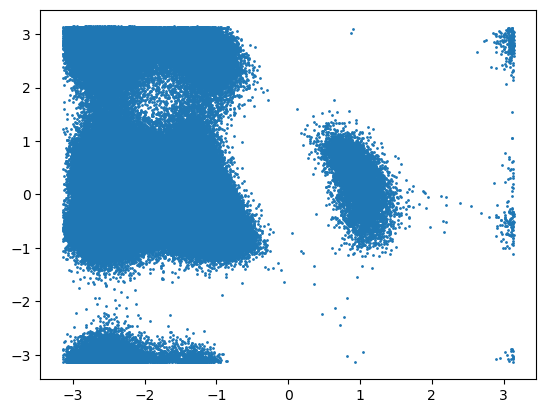

In [5]:
plt.scatter(dihedral[:,0], dihedral[:,1], s=1)
plt.show()

## 2- Compute RMSD distance matrix

### Get subsample of the dataset

In [6]:
conformations = get_conformations(aladip_implicit)

In [7]:
conform_sample = get_sample_conformation(conformations, 400)

In [4]:
dihedral_sample = get_dihedral_sample(dihedral, 70)

In [8]:
conform_sample[5][0]

array([[24.888, 24.699, 25.135],
       [24.965, 24.807, 25.063],
       [25.085, 24.797, 25.042],
       [24.89 , 24.915, 25.038],
       [24.925, 25.016, 24.95 ],
       [24.798, 25.078, 24.899],
       [25.009, 25.132, 25.012],
       [25.058, 25.222, 24.944],
       [25.023, 25.126, 25.149],
       [25.078, 25.235, 25.225]])

### Compute matrix

In [138]:
RMSD_m_sample = compute_RMSD_matrix(conform_sample)

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 75.90it/s]


In [29]:
## Save the matrix in a text file
#np.savetxt('../data/RMSD_sample_matrix.txt', RMSD_m_sample)

In [5]:
# Read the matrix from the text file if not computed 
RMSD_m_sample = np.loadtxt('../data/RMSD_sample_matrix_20000.txt')

In [6]:
RMSD_m_sample.shape

(20297, 20297)

## 3- Produce embedding in 2 dimensions

### Apply MDS to produce 2D embedding of the RMSD matrix

In [ ]:
mds_model = manifold.MDS(n_components = 2, random_state = 123,
    dissimilarity = 'precomputed')
mds_fit = mds_model.fit(RMSD_m_sample)  
mds_coords = mds_model.fit_transform(RMSD_m_sample) 

### Visualise

In [ ]:
plt.scatter(mds_coords[:,0],mds_coords[:,1], s=1)
plt.show()

## 4- ToMATo

## kNN graph type

### Influence of density 


 >>> Plot for DTM density


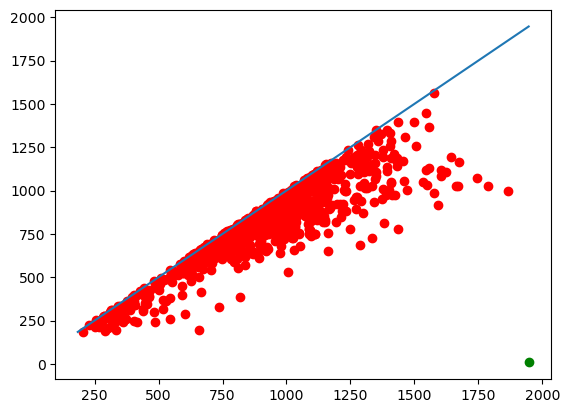


 >>> Plot for logDTM density


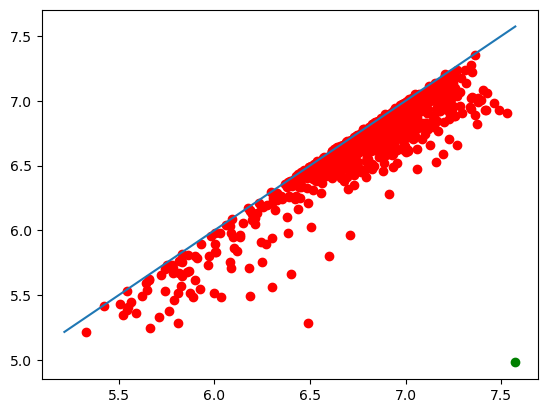

In [5]:
density_types = ['DTM', 'logDTM'] # We can't test KDE and logKDE density functions, because metric is "precomputed"
# symmetrize_graph=> no influence 
for density in density_types:
    t = Tomato(density_type=density, metric="precomputed", n_jobs=-1)
    t.fit(RMSD_m_sample)
    print(f"\n >>> Plot for {density} density")
    t.plot_diagram()

We will keep logDTM density, as if better separates the noise from the peaks.

### Influence of number of neighbors in the kNN 


 >>> Plot for 5 neireast neighbors


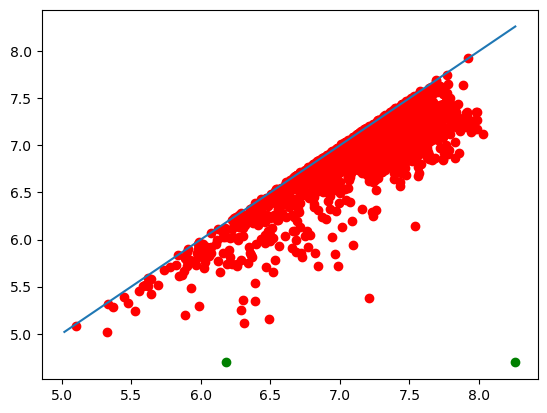


 >>> Plot for 10 neireast neighbors


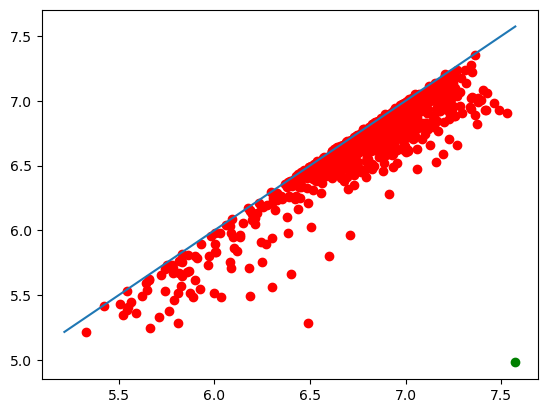


 >>> Plot for 20 neireast neighbors


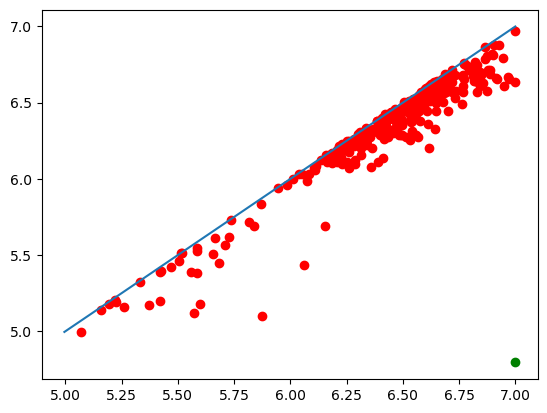


 >>> Plot for 30 neireast neighbors


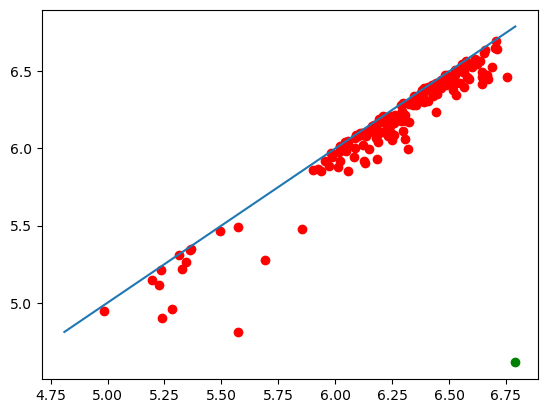


 >>> Plot for 50 neireast neighbors


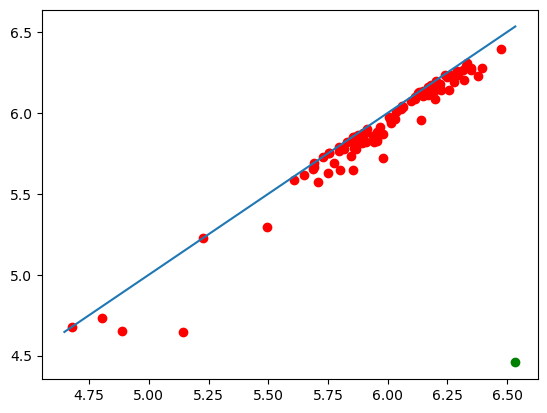


 >>> Plot for 100 neireast neighbors


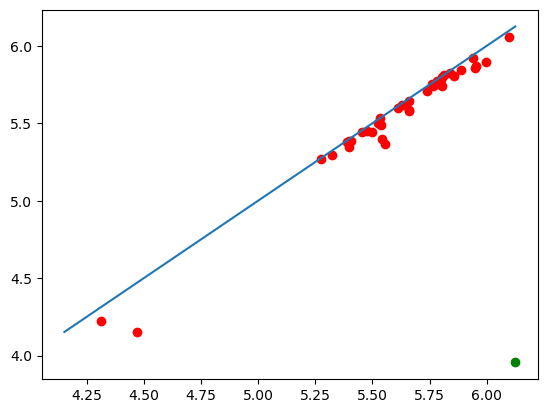


 >>> Plot for 200 neireast neighbors


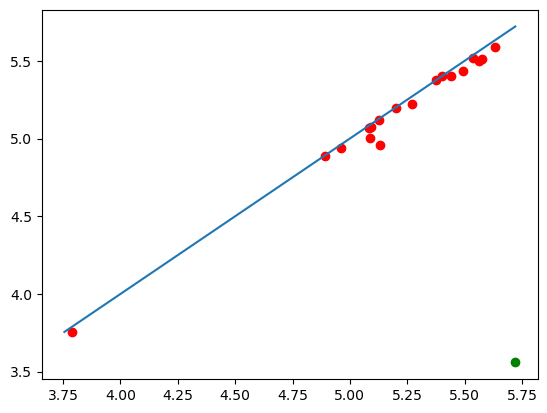

In [6]:
knns = [5, 10, 20, 30, 50, 100, 200] 
for k in knns:
    t = Tomato(density_type='logDTM', metric="precomputed", n_jobs=-1, k=k)
    t.fit(RMSD_m_sample)
    print(f"\n >>> Plot for {k} neareast neighbors")
    t.plot_diagram()

We will keep k=30 for the number of nearest neighbors considered.

### influence of the merge_threshold


 >>> Plot for 0 as merge threhsold


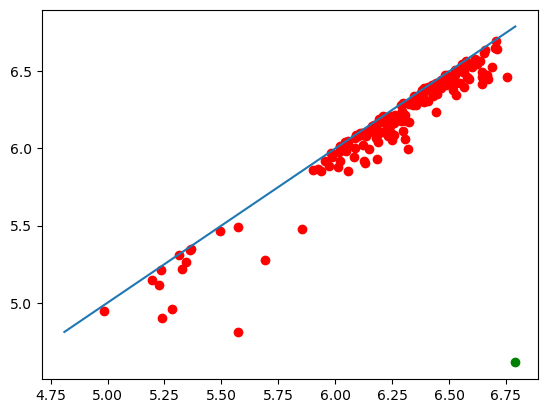


 >>> Plot for 1 as merge threhsold


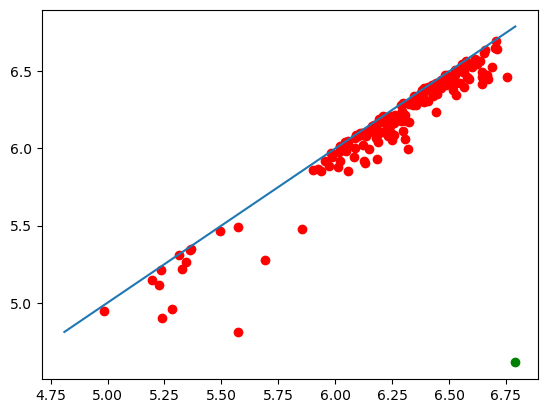


 >>> Plot for 5 as merge threhsold


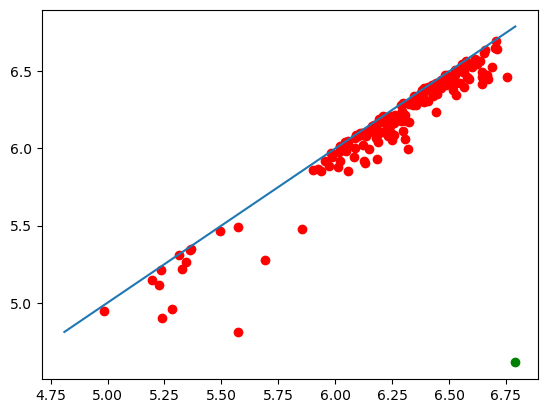


 >>> Plot for 10 as merge threhsold


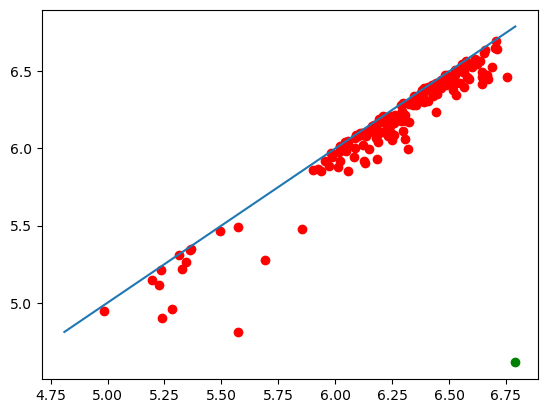


 >>> Plot for 30 as merge threhsold


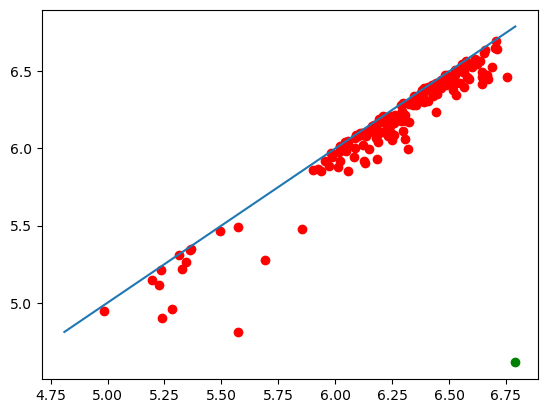


 >>> Plot for 50 as merge threhsold


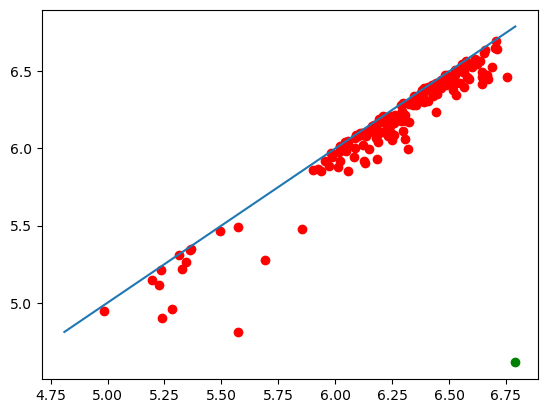


 >>> Plot for 100 as merge threhsold


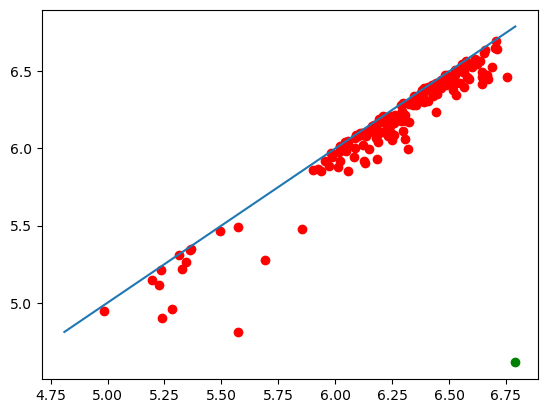

In [16]:
merge_thresholds = [0, 1, 5, 10, 30, 50, 100] 
for merge_threshold in merge_thresholds:
    t = Tomato(density_type='logDTM', metric="precomputed", n_jobs=-1, k=30, merge_threshold_=merge_thresholds)
    t.fit(RMSD_m_sample)
    print(f"\n >>> Plot for {merge_threshold} as merge threhsold")
    t.plot_diagram()

The merge threshold hasn't any influence on the persisstence diagram, so we can't fine-tune this parameter.

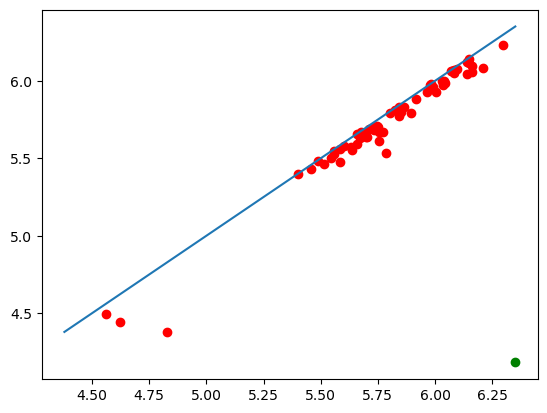

In [16]:
t = Tomato(density_type='logDTM', metric="precomputed", n_jobs=-1, k=70)
t.fit(RMSD_m_sample)
t.plot_diagram()

### Visualize the clustering 

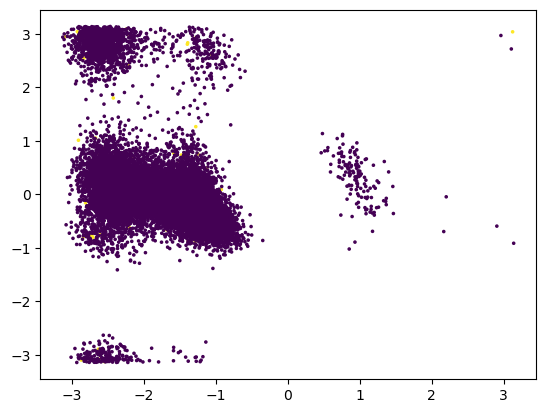

In [19]:
t.n_clusters_ = 2
plt.scatter(dihedral_sample[:,0],dihedral_sample[:,1],marker='.',s=10, c=t.labels_)
plt.show()

## Radius Graph type 


 >>> Plot for 0.1 radius


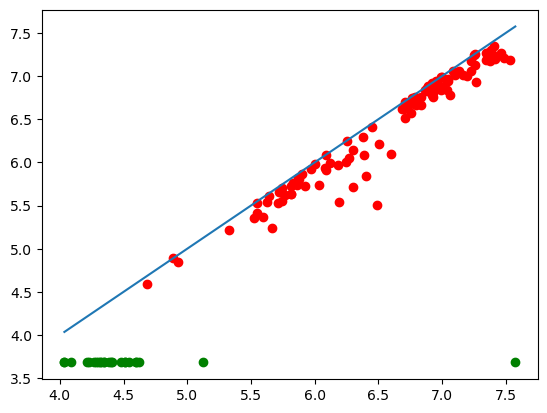


 >>> Plot for 0.13 radius


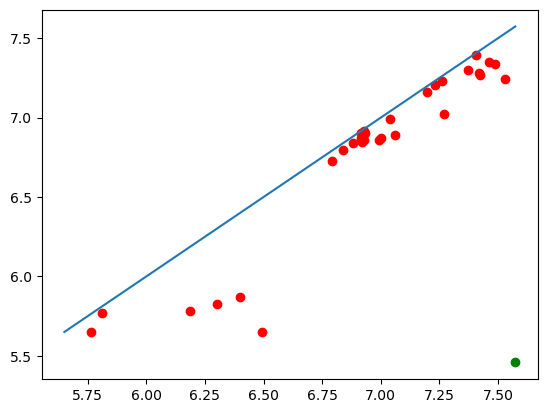


 >>> Plot for 0.15 radius


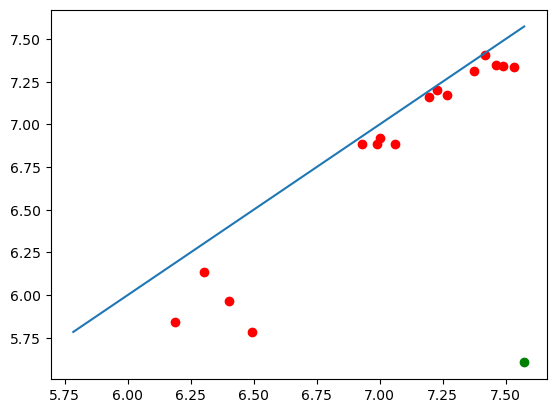


 >>> Plot for 0.17 radius


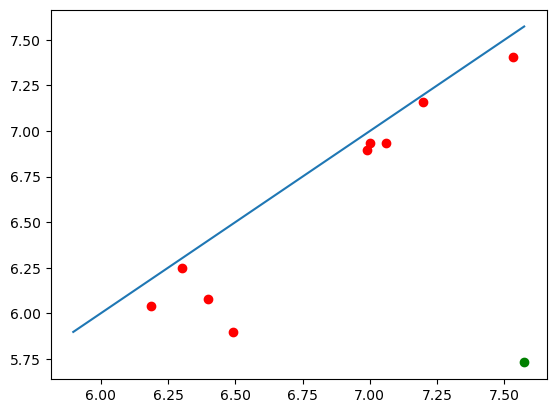


 >>> Plot for 0.2 radius


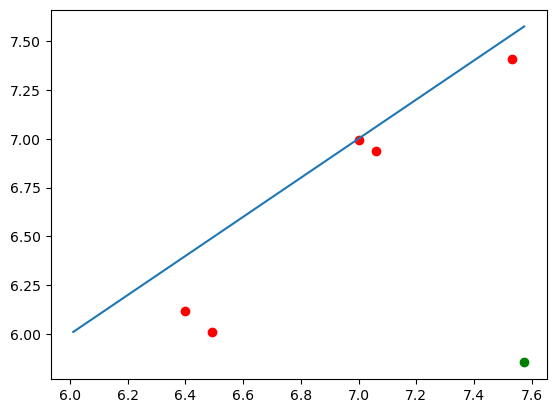


 >>> Plot for 0.25 radius


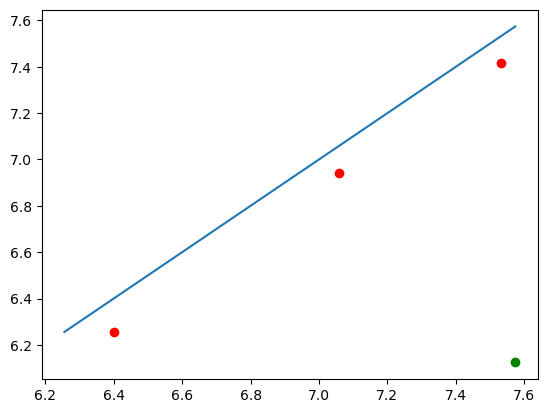

In [20]:
radius = [0.1, 0.13, 0.15, 0.17, 0.2, 0.25]
for r in radius:
    t = Tomato(density_type='logDTM', metric="precomputed", n_jobs=-1, graph_type='radius', r=r)
    print(f"\n >>> Plot for {r} radius")
    t.fit(RMSD_m_sample)
    t.plot_diagram()

### Visualize the clusters 

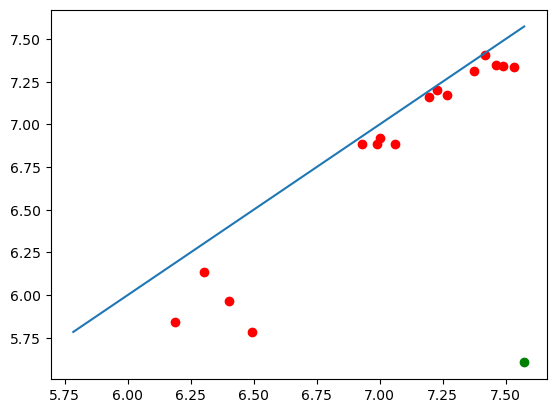

In [24]:
t = Tomato(density_type='logDTM', metric="precomputed", n_jobs=-1, graph_type='radius', r=0.15)
t.fit(RMSD_m_sample)
t.plot_diagram()

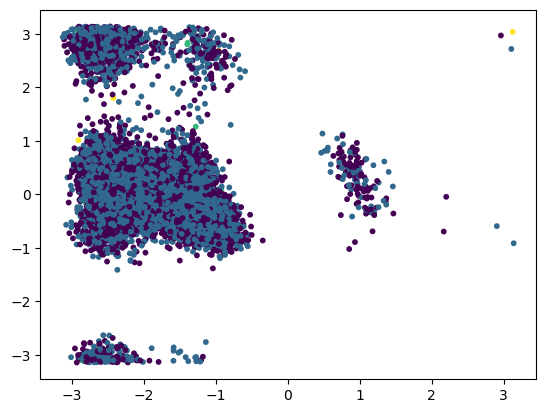

In [23]:
t.n_clusters_=4
plt.scatter(dihedral_sample[:,0],dihedral_sample[:,1],marker='o',s=10, c=t.labels_)
plt.show()